# Problem Formulation

The goal in this challenge is to use satellite imagery to detect and classify the severity of cyanobacteria blooms in small, inland water bodies. This will help water quality managers better allocate resources for in situ sampling and make more informed decisions around public health warnings for drinking water and recreation.


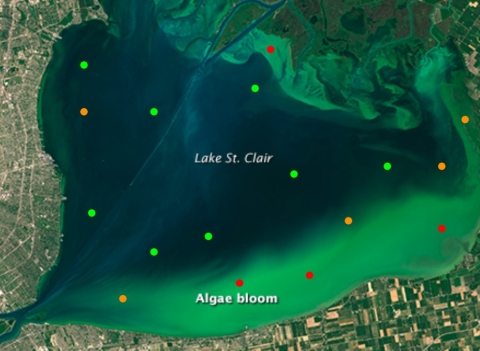

# Environment Setup

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# Data
## Data Collection
1. Satellite imagery: Sentinel-2 or/and Landsat
2. Elevation data; represents the surface of the Earth including buildings, infrastructure, and vegetation. This DSM is based on radar satellite data acquired during the TanDEM-X Mission. [Example notebook](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30#Example-Notebook)



**data sources**:

cyanobacteria density dataset: https://seabass.gsfc.nasa.gov/archive/NASA_HEADQUARTERS/SGupta/CAML/CAML_2013_2021/archive
## Data Labeling
Labels in this competition are based on “in situ” samples that were collected manually and then analyzed for cyanobacteria density.

## Data Catalog

metadata includes attributes for all of the sample measurements in the data. It has the following columns:

uid (str): unique ID for each row

latitude (float): latitude of the location where the sample was collected

longitude (float): longitude of the location where the sample was collected

date (pd.datetime): date when the sample was collected, in the format YYYY-MM-DD

region: metadata given region of US

cluster: arbitrary binning of lat/lon into different clusters (based on looking at distribution of lat/lon)


maxe: maximum elevation within 1000 meters of lat/lon (from DEM)

dife: difference in min/max elevation of 1000 meters (from DEM)

elevation: elevation at exact lat/lon (from DEM)

imtype: image type (ended up only using Sentinel images, filtered out landsat entirely)

prop_lake_2500: Estimate of water area at 2500 meters from lat/lon

r_2500: estimate of red inside water area at 2500 meters

g_2500: estimate of green inside water area at 2500 meters

b_2500: estimate of blue inside water area at 2500 meters

prop_lake_1000: Estimate of water area at 1000 meters from lat/lon

r_1000: estimate of red inside water area at 1000 meters

g_1000: estimate of green inside water area at 1000 meters

b_1000: estimate of blue inside water area at 1000 meters

### read data

In [ ]:
from SB_support import readSB

In [ ]:
data = readSB(filename='0c233b5a95_CAML_cyanobacteria_abundance_20211229_R1.sb')

In [ ]:
data.headers

OrderedDict([('identifier_product_doi', '10.5067/SeaBASS/CAML/DATA001'),
             ('received', '20240320'),
             ('investigators',
              'Shobhana_Gupta,Emily_Gelbart,Ritwik_Gupta,Katie_Wetstone,Emily_Dorne'),
             ('affiliations',
              'NASA_Headquarters,NASA_Headquarters,University_of_California_Berkeley,DataDriven,DataDriven'),
             ('contact', 'shobhana.gupta@gmail.com,egelbart@ttu.edu'),
             ('station', 'NA'),
             ('data_status', 'final'),
             ('experiment', 'CAML'),
             ('cruise', 'CAML_2013_2021'),
             ('data_file_name', 'CAML_cyanobacteria_abundance_20211229_R1.sb'),
             ('documents',
              'User_Manual_for_Cyanobacteria_Aggregated_Manual_Labels_CAML_Dataset.pdf'),
             ('calibration_files', 'no_cal_files'),
             ('measurement_depth', '9999'),
             ('water_depth', 'NA'),
             ('data_use_warning', 'negative_data_values'),
             ('data_

In [ ]:
type(data.data)

collections.OrderedDict

In [ ]:
metadata_df = pd.DataFrame.from_dict(data.data)


In [ ]:
metadata_df.head()

,uid,data_provider,region,lat,lon,date,time,abun,severity,distance_to_water_m
0,aabm,Indiana_State_Department_of_Health,midwest,39.080319,-86.430867,20180514,15:00:00,0.585,1,0
1,aabn,California_Environmental_Data_Exchange_Network,west,36.559700,-121.510000,20160831,16:15:00,5867.500,4,3512
2,aacd,NC_Division_of_Water_Resources_NC_Department_o...,south,35.875083,-78.878434,20201119,0:01:00,0.290,1,514
3,aaee,NC_Division_of_Water_Resources_NC_Department_o...,south,35.487000,-79.062133,20160824,0:01:00,1.614,1,129
4,aaff,Bureau_of_Water_Kansas_Department_of_Health_an...,midwest,38.049471,-99.827001,20190723,0:01:00,111.825,3,19


In [ ]:
metadata_df.shape

(23570, 10)

In [ ]:
metadata_df['uid'].unique().shape

(23570,)

In [ ]:
sat_df = pd.read_csv('sat.csv')
sat_df

,imtype,prop_lake_500,r_500,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500,uid,DateTime
0,land_sat,0.121242,187.752066,183.851240,161.462810,0.069314,185.934307,182.930657,160.817518,0.028575,166.559885,164.792208,145.976912,aabm,2022-12-28 15:29:11.359087+00:00
1,sentinel,0.268989,162.790517,123.633758,84.705945,0.245098,155.874804,120.173824,83.218529,0.275378,154.154273,123.138319,81.460558,aabn,2022-12-28 15:29:17.329306+00:00
2,sentinel,0.137996,136.555328,120.121585,94.683743,0.087424,167.504627,155.254219,135.638269,0.160221,158.483822,143.132806,120.706959,aacd,2022-12-28 15:29:22.858306+00:00
3,sentinel,0.298827,239.129624,197.537794,156.581859,0.197971,229.735649,188.723331,146.595467,0.102113,205.936458,168.080443,128.281072,aaff,2022-12-28 15:29:29.460306+00:00
4,sentinel,0.442114,228.552106,234.636585,230.343681,0.349125,238.247501,242.393052,239.020702,0.252126,243.033961,245.751794,243.296854,aafl,2022-12-28 15:32:00.510235+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,sentinel,0.481143,71.474583,73.984284,63.356034,0.278286,77.264466,78.876106,66.420779,0.247150,79.164519,82.397814,68.899489,zzlt,2022-12-30 07:33:21.835030+00:00
9349,sentinel,0.442890,117.520095,109.741027,79.738878,0.429907,119.292493,113.628528,79.721536,0.344388,131.174634,115.132354,87.398298,zzqy,2022-12-30 07:33:30.666712+00:00
9350,sentinel,0.292690,140.176911,104.834146,75.763902,0.199707,175.601131,147.718686,120.277343,0.507990,143.352693,104.148130,75.892161,zzrv,2022-12-30 07:33:38.246856+00:00
9351,sentinel,0.230296,84.403589,98.742487,61.368531,0.504878,97.434140,102.849292,67.488186,0.210145,160.586596,138.305893,101.340153,zzwo,2022-12-30 07:33:47.450767+00:00


In [ ]:
spat_lag_df = pd.read_csv('spat_lag.csv')
spat_lag_df

,severity_100,logDensity_100,severity_300,logDensity_300,severity_1000,logDensity_1000,count_100,count_300,count_1000,uid,DateTime
0,2.411111,11.131530,2.497326,11.395510,1.644384,9.398106,90,187,7719,aabm,2022-12-27 16:14:33.910241+00:00
1,3.995575,15.453825,3.910702,14.937537,3.912492,14.950303,226,1467,1497,aabn,2022-12-27 16:14:33.910241+00:00
2,1.550748,9.301673,1.550918,9.302172,1.608928,9.349205,8552,8553,10461,aacd,2022-12-27 16:14:33.910241+00:00
3,1.540097,9.213549,1.540097,9.213549,1.539900,9.159562,4140,4140,4599,aaee,2022-12-27 16:14:33.910241+00:00
4,3.027778,12.868044,2.546218,11.780140,2.334434,11.060419,36,833,1211,aaff,2022-12-27 16:14:33.910241+00:00
...,...,...,...,...,...,...,...,...,...,...,...
23565,4.000000,15.531695,3.901034,15.062077,3.902047,15.067086,127,677,684,zzvv,2022-12-27 16:14:33.910241+00:00
23566,2.473684,11.742183,2.395397,11.495304,2.165775,10.629290,38,478,748,zzwo,2022-12-27 16:14:33.910241+00:00
23567,1.469217,9.052822,1.469217,9.052822,1.457373,8.969123,1673,1673,1865,zzwq,2022-12-27 16:14:33.910241+00:00
23568,1.544295,9.224871,1.544295,9.224871,1.544418,9.167340,4549,4549,5088,zzyb,2022-12-27 16:14:33.910241+00:00


In [ ]:
elevation_dem_df = pd.read_csv('elevation_dem.csv')
elevation_dem_df

,latitude,longitude,box,elevation,mine,maxe,dife,avge,stde,uid,DateTime
0,35.980000,-78.840901,1000,101.566254,87.542809,130.299011,42.756203,107.346771,8.125100,fvyy,2022-12-22 14:33:31.710640+00:00
1,37.660000,-120.875000,1000,33.648495,26.232449,47.663738,21.431290,38.601562,3.300400,xvyt,2022-12-22 14:33:31.710640+00:00
2,36.130000,-79.067917,1000,187.980103,159.908417,225.662064,65.753647,196.376556,9.686280,gfrm,2022-12-22 14:33:31.710640+00:00
3,35.742000,-79.224930,1000,140.991028,127.858162,191.056915,63.198753,155.453690,10.969849,zmbr,2022-12-22 14:33:31.710640+00:00
4,35.790000,-79.031929,1000,107.646332,62.625713,146.481781,83.856064,94.722862,25.895313,bpvi,2022-12-22 14:33:31.710640+00:00
...,...,...,...,...,...,...,...,...,...,...,...
23565,39.792190,-99.971050,1000,697.500000,697.500000,732.066223,34.566223,702.116211,5.649322,zzwo,2022-12-22 14:33:31.710640+00:00
23566,35.794000,-79.012551,1000,64.000000,64.000000,104.038414,40.038414,67.490509,7.727036,zzwq,2022-12-22 14:33:31.710640+00:00
23567,35.742000,-79.238600,1000,164.907166,133.443787,191.056915,57.613129,160.309174,8.871887,zzyb,2022-12-22 14:33:31.710640+00:00
23568,39.767323,-96.028617,1000,350.000000,345.187805,388.496033,43.308228,363.472412,9.798910,zzzi,2022-12-22 14:33:31.710640+00:00


### merge data

In [ ]:
# 1. Merge metadata_df (meta) with elevation_dem_df (elevation_dem)
merged_df = metadata_df.merge(elevation_dem_df, on='uid', how='left')

# 2. Merge the result with spat_lag_df (spat_lag)
merged_df = merged_df.merge(spat_lag_df, on='uid', how='left')

# 3. Merge the result with sat_df (sat)
merged_df = merged_df.merge(sat_df, on='uid', how='left')

# The labels are assumed to be part of metadata_df, so no need to join them separately




In [ ]:
merged_df.columns

Index(['uid', 'data_provider', 'region', 'lat', 'lon', 'date', 'time', 'abun',
       'severity', 'distance_to_water_m', 'latitude', 'longitude', 'box',
       'elevation', 'mine', 'maxe', 'dife', 'avge', 'stde', 'DateTime_x',
       'severity_100', 'logDensity_100', 'severity_300', 'logDensity_300',
       'severity_1000', 'logDensity_1000', 'count_100', 'count_300',
       'count_1000', 'DateTime_y', 'imtype', 'prop_lake_500', 'r_500', 'g_500',
       'b_500', 'prop_lake_1000', 'r_1000', 'g_1000', 'b_1000',
       'prop_lake_2500', 'r_2500', 'g_2500', 'b_2500', 'DateTime'],
      dtype='object')

In [ ]:
# Select the columns in the desired order
final_df = merged_df[
    ['uid', 'region', 'severity', 'latitude', 'longitude', 'date',
     'elevation', 'mine', 'maxe', 'dife', 'avge', 'stde',
     'severity_100', 'logDensity_100', 'count_100',
     'severity_300', 'logDensity_300', 'count_300',
     'severity_1000', 'logDensity_1000', 'count_1000',
     'imtype', 'prop_lake_500', 'r_500', 'g_500', 'b_500',
     'prop_lake_1000', 'r_1000', 'g_1000', 'b_1000',
     'prop_lake_2500', 'r_2500', 'g_2500', 'b_2500'
    ]
]

final_df.head()

,uid,region,severity,latitude,longitude,date,elevation,mine,maxe,dife,...,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500
0,aabm,midwest,1,39.080319,-86.430867,20180514,164.000000,162.775070,245.746124,82.971054,...,183.851240,161.462810,0.069314,185.934307,182.930657,160.817518,0.028575,166.559885,164.792208,145.976912
1,aabn,west,4,36.559700,-121.510000,20160831,30.869383,28.244602,49.591141,21.346539,...,123.633758,84.705945,0.245098,155.874804,120.173824,83.218529,0.275378,154.154273,123.138319,81.460558
2,aacd,south,1,35.875083,-78.878434,20201119,112.367500,82.372543,124.047012,41.674469,...,120.121585,94.683743,0.087424,167.504627,155.254219,135.638269,0.160221,158.483822,143.132806,120.706959
3,aaee,south,1,35.487000,-79.062133,20160824,133.678329,94.498573,160.707916,66.209343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aaff,midwest,3,38.049471,-99.827001,20190723,693.751953,685.274170,726.738892,41.464722,...,197.537794,156.581859,0.197971,229.735649,188.723331,146.595467,0.102113,205.936458,168.080443,128.281072


### EDA

In [ ]:
final_df.shape

(23570, 34)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uid              23570 non-null  object 
 1   region           23570 non-null  object 
 2   severity         23570 non-null  int64  
 3   latitude         23570 non-null  float64
 4   longitude        23570 non-null  float64
 5   date             23570 non-null  int64  
 6   elevation        23570 non-null  float64
 7   mine             23570 non-null  float64
 8   maxe             23570 non-null  float64
 9   dife             23570 non-null  float64
 10  avge             23570 non-null  float64
 11  stde             23570 non-null  float64
 12  severity_100     23570 non-null  float64
 13  logDensity_100   23570 non-null  float64
 14  count_100        23570 non-null  int64  
 15  severity_300     23570 non-null  float64
 16  logDensity_300   23570 non-null  float64
 17  count_300   

In [ ]:
final_df.describe()

,severity,latitude,longitude,date,elevation,mine,maxe,dife,avge,stde,...,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500
count,23570.000000,23570.000000,23570.000000,2.357000e+04,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,...,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000
mean,2.253246,37.599112,-91.438307,2.017155e+07,175.416188,159.612456,218.089806,58.477350,182.174718,11.890973,...,118.186496,90.797906,0.273842,132.651309,120.987224,93.590110,0.255629,135.830224,122.344628,95.336929
std,1.238762,2.823860,17.886877,2.390527e+04,273.668598,269.082678,296.131317,55.980386,278.927905,13.567918,...,48.595939,48.111461,0.176043,53.732413,45.918708,46.179445,0.160341,50.024667,42.884688,43.941418
min,1.000000,26.389430,-124.179200,2.013010e+07,-6.573961,-8.489909,0.000000,0.000000,-5.039981,0.000000,...,1.000000,1.000000,0.000335,1.000000,1.000000,1.000000,0.000042,1.000000,1.000000,1.000000
25%,1.000000,35.700925,-109.370945,2.015082e+07,56.113747,45.532188,97.374672,23.930344,65.147533,4.125027,...,85.383862,56.983360,0.140635,90.426307,88.539080,60.687841,0.137606,98.934404,94.342031,65.641969
50%,2.000000,36.228150,-79.268000,2.017080e+07,124.059055,98.498672,162.546829,51.229195,127.206436,9.250443,...,111.767442,81.297004,0.233766,131.699970,115.959786,84.940215,0.217252,136.133842,119.375113,88.279942
75%,4.000000,38.930270,-79.026108,2.019080e+07,180.500000,173.500000,229.550110,68.817337,184.266804,13.593365,...,145.612996,111.635373,0.375878,173.576494,148.949142,116.391888,0.344484,171.698004,147.204473,115.580552
max,5.000000,48.973250,-67.698650,2.021123e+07,3547.000000,3365.940430,3988.470703,1078.071045,3618.695068,213.942810,...,255.000000,255.000000,1.000000,255.000000,255.000000,255.000000,1.000000,255.000000,255.000000,255.000000


In [ ]:
final_df['imtype'].unique()

array(['land_sat', 'sentinel', nan], dtype=object)

In [ ]:
final_df['severity'].unique()

array([1, 4, 3, 2, 5])

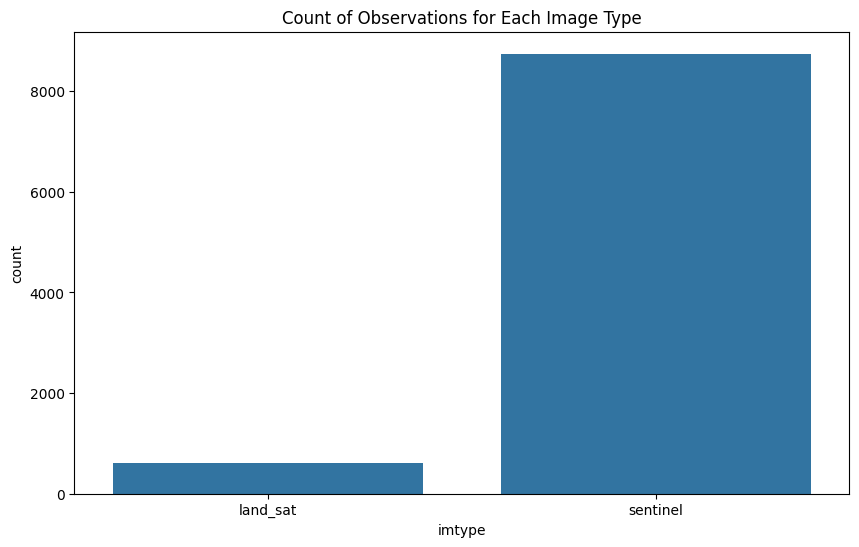

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='imtype', data=final_df)
plt.title('Count of Observations for Each Image Type')
plt.show()


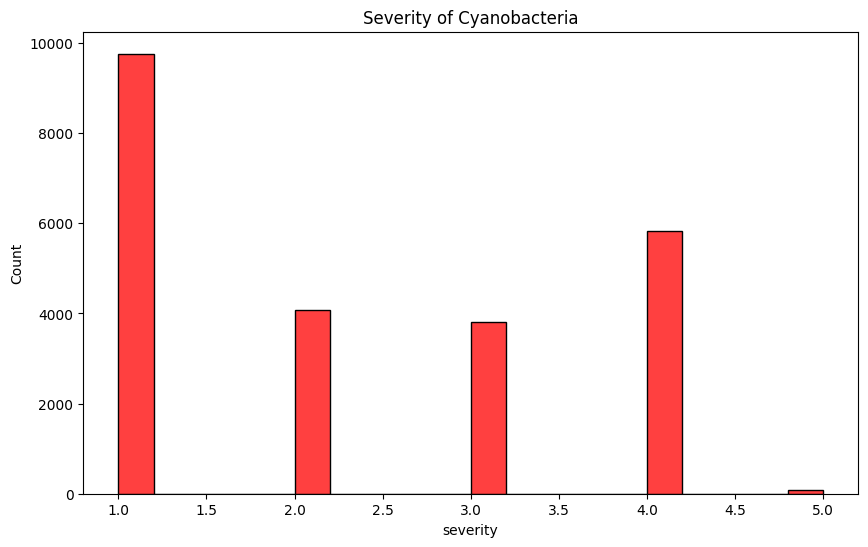

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(final_df['severity'], color='red')
plt.title('Severity of Cyanobacteria')
plt.show()


In [ ]:
final_df.head()

,uid,region,severity,latitude,longitude,date,elevation,mine,maxe,dife,...,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500
0,aabm,midwest,1,39.080319,-86.430867,20180514,164.000000,162.775070,245.746124,82.971054,...,183.851240,161.462810,0.069314,185.934307,182.930657,160.817518,0.028575,166.559885,164.792208,145.976912
1,aabn,west,4,36.559700,-121.510000,20160831,30.869383,28.244602,49.591141,21.346539,...,123.633758,84.705945,0.245098,155.874804,120.173824,83.218529,0.275378,154.154273,123.138319,81.460558
2,aacd,south,1,35.875083,-78.878434,20201119,112.367500,82.372543,124.047012,41.674469,...,120.121585,94.683743,0.087424,167.504627,155.254219,135.638269,0.160221,158.483822,143.132806,120.706959
3,aaee,south,1,35.487000,-79.062133,20160824,133.678329,94.498573,160.707916,66.209343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aaff,midwest,3,38.049471,-99.827001,20190723,693.751953,685.274170,726.738892,41.464722,...,197.537794,156.581859,0.197971,229.735649,188.723331,146.595467,0.102113,205.936458,168.080443,128.281072


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip



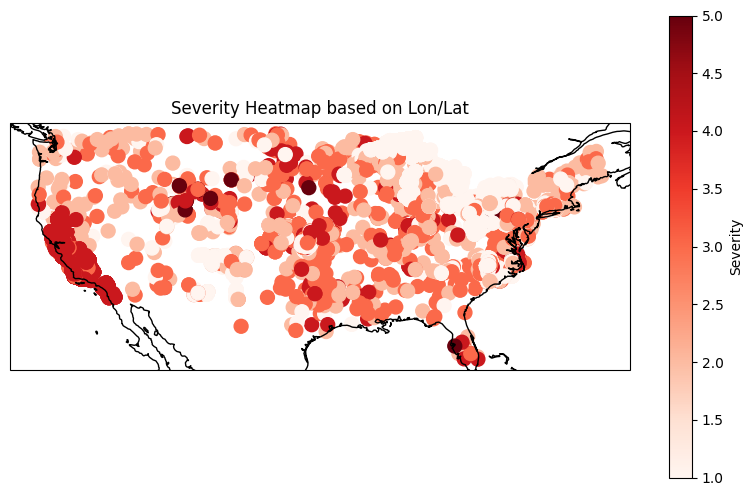

In [ ]:
# Create a figure and axis with a geographic projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set up the map: you can use features such as coastlines or country borders
ax.coastlines()

# Convert your lon, lat, and severity to a heatmap using hexbin
sc = ax.scatter(final_df['longitude'], final_df['latitude'], c=final_df['severity'], cmap='Reds', s=100)

# Add a colorbar to represent the severity
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Severity')

# Set labels and title
plt.title("Severity Heatmap based on Lon/Lat")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
# Create a scatter geo plot using Plotly Express
fig = px.scatter_geo(final_df,
                     lon='longitude',
                     lat='latitude',
                     color='severity',
                     color_continuous_scale='Reds',
                     size_max=15,
                     projection="natural earth")

# Update layout for better visualization
fig.update_layout(
    title="Severity Heatmap based on Lon/Lat",
    geo=dict(
        showcoastlines=True,  # Add coastlines
        coastlinecolor="Black"
    )
)

# Show the plot
fig.show()

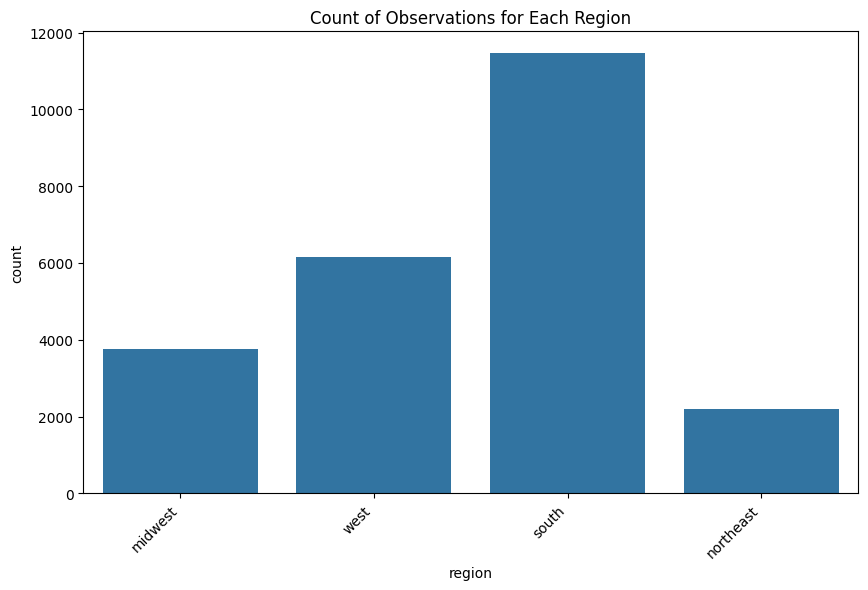

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='region', data=final_df)
plt.title('Count of Observations for Each Region')
plt.xticks(rotation=45, ha='right')
plt.show()


Text(0, 0.5, 'Count')

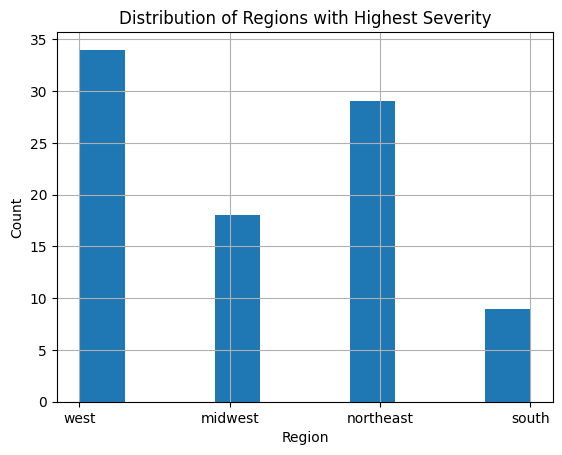

In [ ]:
final_df[final_df['severity'] == final_df['severity'].max()]['region'].hist()
plt.title('Distribution of Regions with Highest Severity')
plt.xlabel('Region')
plt.ylabel('Count')

In [ ]:
# TODO dealing with dates

In [ ]:
# check correlation with severity

# correlation_matrix = final_df.corr()
# severity_correlation = correlation_matrix['severity'].sort_values(ascending=False)
# print(severity_correlation)


# Preprocessing

In [ ]:
X = final_df.drop(['uid', 'severity', 'date', 'region', 'imtype'], axis=1)  # Features
y = final_df['severity']  # Target variable

In [ ]:
# Handle missing values (replace with mean or median)
X.fillna(X.mean(), inplace=True)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Feature scaling (optional but recommended for some algorithms)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

In [ ]:
# Train a model (e.g., Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

# You can further improve the model by:
# - Trying different algorithms (e.g., SVM, XGBoost)
# - Hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV
# - Feature engineering (creating new features based on existing ones)


Accuracy: 0.6694951209164192
              precision    recall  f1-score   support

           1       0.73      0.77      0.75      1922
           2       0.33      0.31      0.32       797
           3       0.47      0.43      0.45       789
           4       0.90      0.91      0.91      1185
           5       0.27      0.14      0.19        21

    accuracy                           0.67      4714
   macro avg       0.54      0.51      0.52      4714
weighted avg       0.66      0.67      0.66      4714



In [ ]:
# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(final_df['severity'].unique()), activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

# Shift labels to be 0-indexed
y_train = y_train - 1
y_test = y_test - 1

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6047 - loss: 1.0241 - val_accuracy: 0.6620 - val_loss: 0.8505
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6610 - loss: 0.8646 - val_accuracy: 0.6644 - val_loss: 0.8402
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6695 - loss: 0.8519 - val_accuracy: 0.6686 - val_loss: 0.8329
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6734 - loss: 0.8359 - val_accuracy: 0.6691 - val_loss: 0.8229
Epoch 5/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6771 - loss: 0.8279 - val_accuracy: 0.6702 - val_loss: 0.8175
Epoch 6/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6713 - loss: 0.8302 - val_accuracy: 0.6721 - val_loss: 0.8160
Epoch 7/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6725 - loss: 0.8254 - val_accuracy: 0.6697 - val_loss: 0.8186
Epoch 8/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6762 - loss: 0.8167 - val_accuracy: 0.6726 - val

# References
- https://www.earthdata.nasa.gov/learn/blog/cyanobacteria-finder
- https://www.drivendata.org/competitions/143/tick-tick-bloom/page/649/
- https://github.com/drivendataorg/tick-tick-bloom/tree/main
- https://github.com/drivendataorg/cyfi